# 83강 특이값 분해 - 이미지손실압축 예제

- [frankcleary 주피터](https://nbviewer.jupyter.org/gist/frankcleary/4d2bd178708503b556b0)를 참고했다.
- 이전에 고유값 벡터로 이미지를 근사하는 예제를 만들어봤었다.
- 이번에는 SVD로 근사치를 계산하는 예제를 만들어본다.
- 흑백이미지로 테스트 한다.

### TOC
1. 넘파이 함수 확인 - np.linalg.svd()
1. 근사치 계산 로직 정리
1. 특이값 분해 - 정방행렬
1. 특이값 분해 - 가로가 긴 이미지
1. 특이값 분해 - 세로가 긴 이미지

## 넘파이 함수 확인
- 넘파이의 np.linalg.svd()로 특이값 분해를 한다.
- np.linalg.svd()를 이용하여
$A$행렬을 $ U \Sigma V^T$로 분해한 뒤 다시 곱하면 원래 $A$가 나오는 것을 확인해보자.

In [29]:
import matplotlib.pylab as plt
import numpy as np
import functools

In [30]:
a = np.array([[2,3,4],[4,2,5],[7,8,9]])
U,sigma,VT = np.linalg.svd(a)

print('Left Singular Matrix =', U.shape)
print('Singular values =', sigma)
print('Right Singular Matrix =', VT.shape)

# 분해해서 다시 곱하면 원래 행렬값과 동일한 것을 알 수 있다.
U @ np.diag(sigma) @ VT

Left Singular Matrix = (3, 3)
Singular values = [16.24219726  1.87549967  0.82068829]
Right Singular Matrix = (3, 3)


array([[2., 3., 4.],
       [4., 2., 5.],
       [7., 8., 9.]])

### 근사치 계산 로직 정리
**계산의 효율성 문제**
- 예를 들어 너비가 200인 정사각 이미지를, N=2로 근사치 행렬을 만들려면?

- $ U \Sigma V^T $에서 $ \Sigma $의 대각원소는 200개

- N=2로 근사치 행렬을 만든다는 것은 $ \Sigma $의 대각원소를 2개만 사용하겠다는 의미

- 그러면 $ \Sigma $의 세번째 이후의 대각원소를 0으로 두고 행렬을 곱해야겠다고 생각했다.

- 물론 이렇게 해도 되지만, 불필요한 행렬곱셈을 하게 된다.
    - 세번째 대각원소는 0이므로 곱하지 않아도 된다.
    - 따라서 198개의 원소가 의미없이 행렬곱셈에 투입되는 것이다.

**다음과 같이 로직을 정리하면 되겠다**

- N=1이면, 
    - $ \Sigma $는 1행 1열만 사용한다.
    - 그래서 $U\Sigma$ 행렬곱에서 $U$는 200행 1열만 의미가 있다. 다른 열은 곱해도 0이다.
    - 또 $\Sigma V^T$ 행렬곱에서 $V^T$의 1행 200열만 의미가 있다. 다른 행은 곱해도 0이다.
    - 따라서 $N=1$ 일때 행렬곱의 형태는
    $ U_{200x1} \, \Sigma_{1x1} \, V^T_{1x200} $ 


- N=2이면, 
    - $ \Sigma $는 2행 2열만 사용한다.
    - 그래서 $U\Sigma$ 행렬곱에서 $U$의 200행 2열만 의미가 있다. 다른 열은 곱해도 0이다.
    - 또 $\Sigma V^T$ 행렬곱에서 $V^T$도 2행 200열만 의미가 있다. 다른 행은 곱해도 0이다.
    - 따라서 $N=2$ 일때 행렬곱의 형태는
    $ U_{200x2} \, \Sigma_{2x2} \, V^T_{2x200} $


> 그리고 N의 최대값은 특이값의 개수이다.( $\sigma_n$ )



## 특이값 분해 - 정방행렬

In [31]:
# OpenCV 임포트
import cv2

### 공통함수

In [32]:
# matplotlib에 이미지 표시하는 유틸리티 함수
def plot_img(ax, title, img, color=cv2.COLOR_BGR2RGB):
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(img, color))


### 테스트 이미지 준비
- 코드를 단순화하기 위해 흑백이미지로 테스트한다

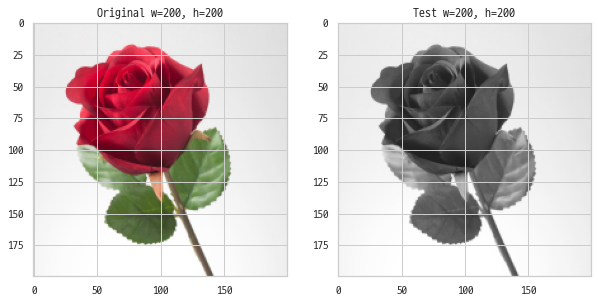

In [33]:
org_img1 = cv2.imread('flower.jpg', cv2.IMREAD_COLOR)
TEST_IMG1 = cv2.cvtColor(org_img1, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
plot_img(ax[0], f'Original w={org_img1.shape[1]}, h={org_img1.shape[0]}', org_img1)
plot_img(ax[1], f'Test w={org_img1.shape[1]}, h={org_img1.shape[0]}', TEST_IMG1)

### 이미지 행렬을 SVD로 분해
- U, sigma, VT 로 분해한다.

In [43]:
U, sigma, VT = np.linalg.svd(TEST_IMG1)
print('Left Singular Matrix =', U.shape)
print('Singular values =', sigma.shape)
print('Right Singular Matrix =', VT.shape)


Left Singular Matrix = (200, 200)
Singular values = (200,)
Right Singular Matrix = (200, 200)


### N에 따라 근사치 행렬을 만드는 함수

In [35]:
# 2차원행렬의 근사치 계산
def approx(n,u_mat, sigma, vt_mat):
    nn = np.min((n, len(sigma)))
    
    # U는 n열만 계산에 포함
    # sigma는 n개만 계산에 포함
    # V는 n행만 계산에 포함
    mat = u_mat[:,:nn] @ np.diag(sigma[:nn]) @ vt_mat[:nn, :]
    # 근사치라서 255보다 조금 클 수도 있고
    # 0보다 조금 작을 수도 있다. 0~255사이로 보정
    return np.clip(mat, 0, 255).astype('uint8')


### N값별로 이미지 확인

(200, 2)
(2, 2)
(2, 200)


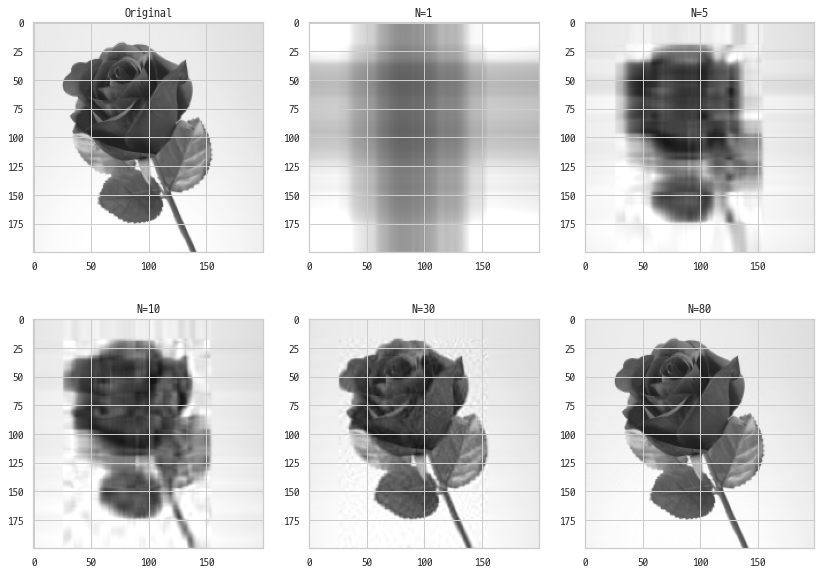

In [36]:
# functools.partial로 함수를 단순화
approximate = functools.partial(approx, 
                                u_mat=U, 
                                sigma=sigma, 
                                vt_mat=VT)
print(U[:,:2].shape)
print(np.diag(sigma[:2]).shape)
print(VT[:2, :].shape)
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(w=14, h=10)
plot_img(ax[0,0], 'Original', TEST_IMG1)
plot_img(ax[0,1], 'N=1', approximate(n=1))
plot_img(ax[0,2], 'N=5', approximate(n=5))
plot_img(ax[1,0], 'N=10', approximate(n=10))
plot_img(ax[1,1], 'N=30', approximate(n=30))
plot_img(ax[1,2], 'N=80', approximate(n=80))

## 특이값 분해 - 가로가 긴 행렬

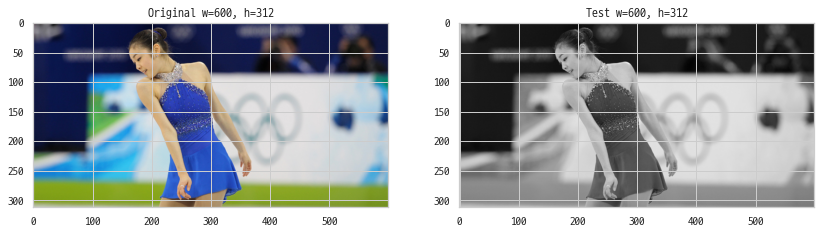

In [37]:
org_img2 = cv2.imread('yeona.jpg', cv2.IMREAD_COLOR)
TEST_IMG2 = cv2.cvtColor(org_img2, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(14,6))
plot_img(ax[0], f'Original w={org_img2.shape[1]}, h={org_img2.shape[0]}', org_img2)
plot_img(ax[1], f'Test w={org_img2.shape[1]}, h={org_img2.shape[0]}', TEST_IMG2)

In [38]:
# height,width = org_img.shape
U, sigma, VT = np.linalg.svd(TEST_IMG2)
print('Left Singular Matrix =', U.shape)
print('Right Singular Matrix =', VT.shape)
print('sigma =', sigma.shape)

Left Singular Matrix = (312, 312)
Right Singular Matrix = (600, 600)
sigma = (312,)


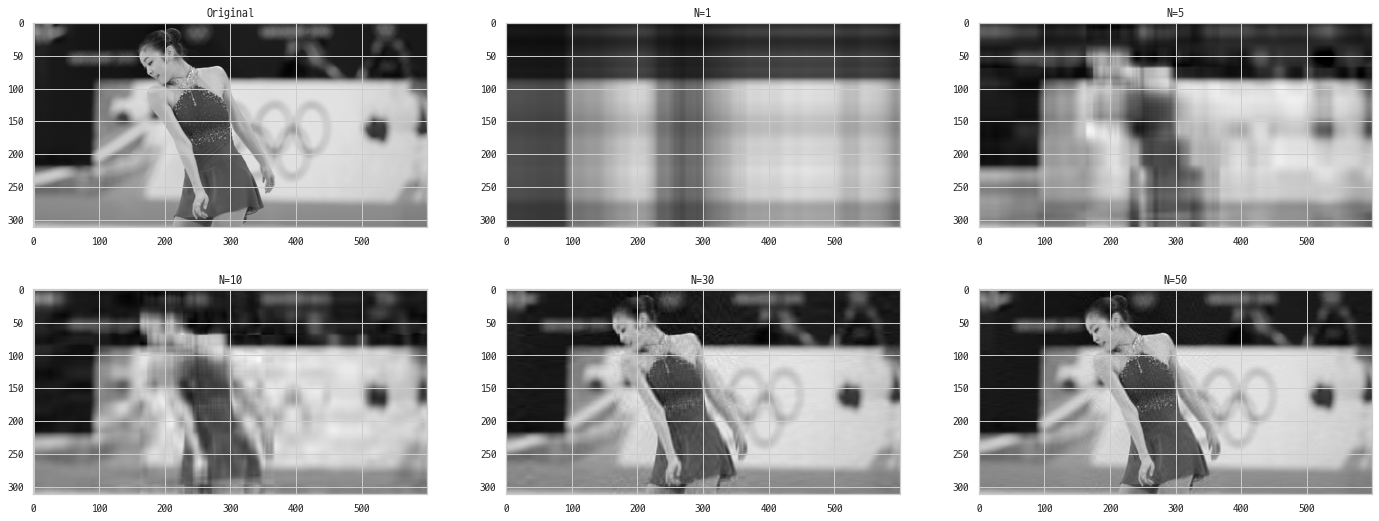

In [39]:
approximate = functools.partial(approx, u_mat=U, sigma=sigma, vt_mat=VT)

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(w=24, h=9)
plot_img(ax[0,0], 'Original', TEST_IMG2)
plot_img(ax[0,1], 'N=1', approximate(n=1))
plot_img(ax[0,2], 'N=5', approximate(n=5))
plot_img(ax[1,0], 'N=10', approximate(n=10))
plot_img(ax[1,1], 'N=30', approximate(n=30))
plot_img(ax[1,2], 'N=50', approximate(n=50))

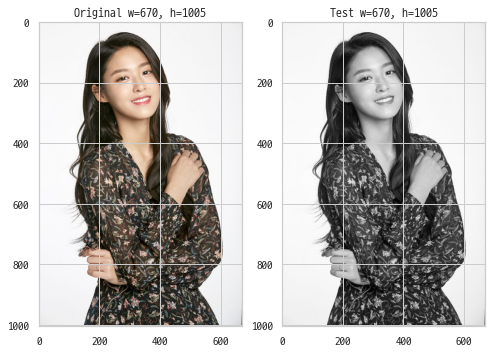

In [40]:
org_img3 = cv2.imread('seolhyun.jpg', cv2.IMREAD_COLOR)
TEST_IMG3 = cv2.cvtColor(org_img3, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(8,6))
plot_img(ax[0], f'Original w={org_img3.shape[1]}, h={org_img3.shape[0]}', org_img3)
plot_img(ax[1], f'Test w={org_img3.shape[1]}, h={org_img3.shape[0]}', TEST_IMG3)

In [41]:
# height,width = org_img.shape
U, sigma, VT = np.linalg.svd(TEST_IMG3)
print('Left Singular Matrix =', U.shape)
print('Right Singular Matrix =', VT.shape)
print('sigma =', sigma.shape)

Left Singular Matrix = (1005, 1005)
Right Singular Matrix = (670, 670)
sigma = (670,)


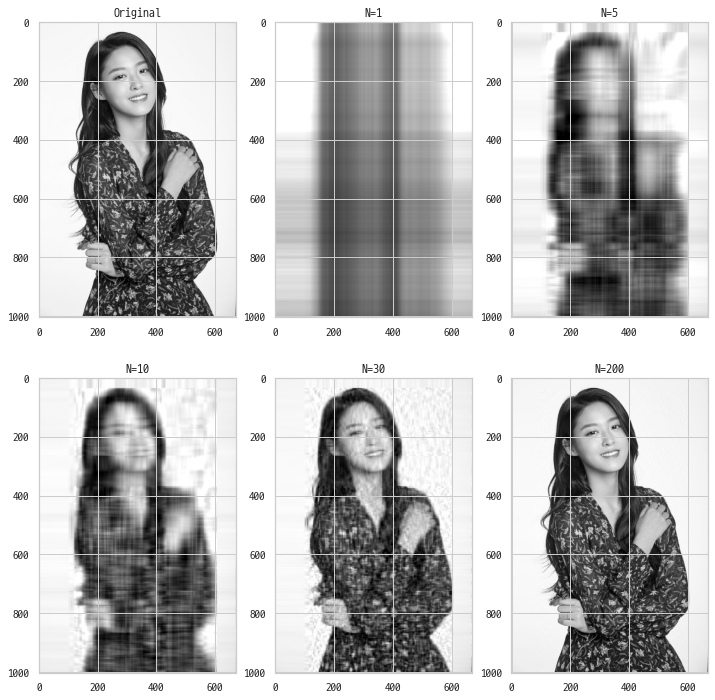

In [42]:
approximate = functools.partial(approx, u_mat=U, sigma=sigma, vt_mat=VT)

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(w=12, h=12)
plot_img(ax[0,0], 'Original', TEST_IMG3)
plot_img(ax[0,1], 'N=1', approximate(n=1))
plot_img(ax[0,2], 'N=5', approximate(n=5))
plot_img(ax[1,0], 'N=10', approximate(n=10))
plot_img(ax[1,1], 'N=30', approximate(n=30))
plot_img(ax[1,2], 'N=200', approximate(n=200))